<a href="https://colab.research.google.com/github/Ris15hab/BirdClassifier/blob/main/GANS_DOGS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
project_name = 'Dog_Image_Gen'

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install opendatasets --upgrade --quiet

In [3]:
import opendatasets as od

dataset_url = 'https://www.kaggle.com/datasets/jessicali9530/stanford-dogs-dataset'
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: rishabpendam1
Your Kaggle Key: ··········


100%|██████████| 750M/750M [00:07<00:00, 101MB/s]


In [4]:
import os

DATA_DIR = '/content/stanford-dogs-dataset/images/Images'
print(os.listdir(DATA_DIR))

['n02112018-Pomeranian', 'n02089078-black-and-tan_coonhound', 'n02093647-Bedlington_terrier', 'n02113712-miniature_poodle', 'n02091635-otterhound', 'n02093859-Kerry_blue_terrier', 'n02094114-Norfolk_terrier', 'n02115913-dhole', 'n02091244-Ibizan_hound', 'n02108915-French_bulldog', 'n02105505-komondor', 'n02097209-standard_schnauzer', 'n02095889-Sealyham_terrier', 'n02099712-Labrador_retriever', 'n02097658-silky_terrier', 'n02102177-Welsh_springer_spaniel', 'n02097130-giant_schnauzer', 'n02086646-Blenheim_spaniel', 'n02108422-bull_mastiff', 'n02109961-Eskimo_dog', 'n02095570-Lakeland_terrier', 'n02106382-Bouvier_des_Flandres', 'n02102318-cocker_spaniel', 'n02094258-Norwich_terrier', 'n02112706-Brabancon_griffon', 'n02111129-Leonberg', 'n02107312-miniature_pinscher', 'n02105412-kelpie', 'n02107574-Greater_Swiss_Mountain_dog', 'n02098286-West_Highland_white_terrier', 'n02088094-Afghan_hound', 'n02105855-Shetland_sheepdog', 'n02101556-clumber', 'n02098105-soft-coated_wheaten_terrier', 'n02

In [5]:
print(os.listdir(DATA_DIR)[:10])

['n02112018-Pomeranian', 'n02089078-black-and-tan_coonhound', 'n02093647-Bedlington_terrier', 'n02113712-miniature_poodle', 'n02091635-otterhound', 'n02093859-Kerry_blue_terrier', 'n02094114-Norfolk_terrier', 'n02115913-dhole', 'n02091244-Ibizan_hound', 'n02108915-French_bulldog']


In [6]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [7]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [8]:
train_ds = ImageFolder(DATA_DIR, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [9]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [11]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

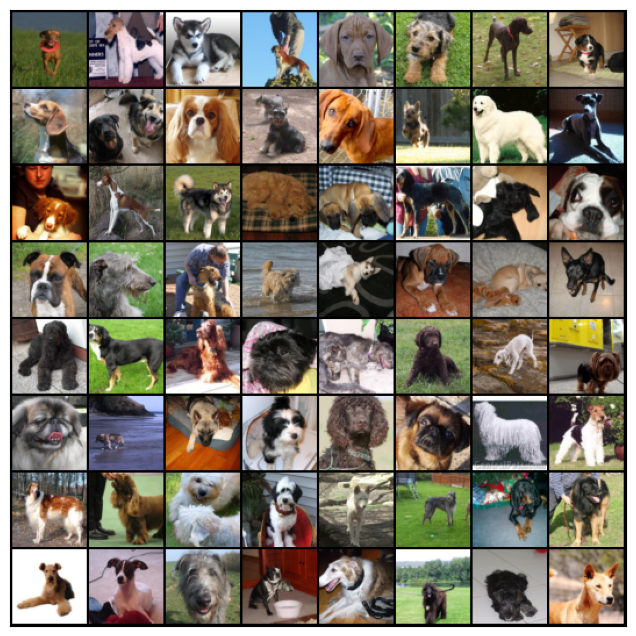

In [12]:
show_batch(train_dl)

In [13]:
!pip install jovian --upgrade --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.6/68.6 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [14]:
import jovian

In [15]:
jovian.commit( filename='my-notebook.ipynb')

[jovian] Detected Colab notebook...
[jovian] jovian.commit() is no longer required on Google Colab. If you ran this notebook from Jovian, 
then just save this file in Colab using Ctrl+S/Cmd+S and it will be updated on Jovian. 
Also, you can also delete this cell, it's no longer necessary.


In [16]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [17]:
device = get_default_device()
device

device(type='cuda')

In [18]:
train_dl = DeviceDataLoader(train_dl, device)

In [19]:
import torch.nn as nn

In [20]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [21]:
discriminator = to_device(discriminator, device)

In [22]:
latent_size = 128

In [23]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

torch.Size([128, 3, 64, 64])


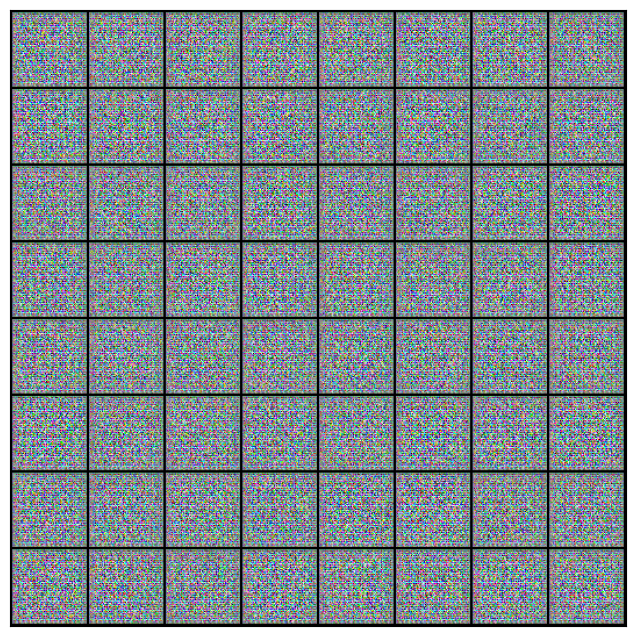

In [24]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [25]:
generator = to_device(generator, device)

In [26]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [27]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)

    # Update generator weights
    loss.backward()
    opt_g.step()

    return loss.item()

In [30]:
jovian.commit(project=project_name, environment=None)

[jovian] Detected Colab notebook...
[jovian] jovian.commit() is no longer required on Google Colab. If you ran this notebook from Jovian, 
then just save this file in Colab using Ctrl+S/Cmd+S and it will be updated on Jovian. 
Also, you can also delete this cell, it's no longer necessary.


In [31]:
from torchvision.utils import save_image

In [32]:
sample_dir = 'drive/MyDrive/generated'
os.makedirs(sample_dir, exist_ok=True)

In [33]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [34]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Saving generated-images-0000.png


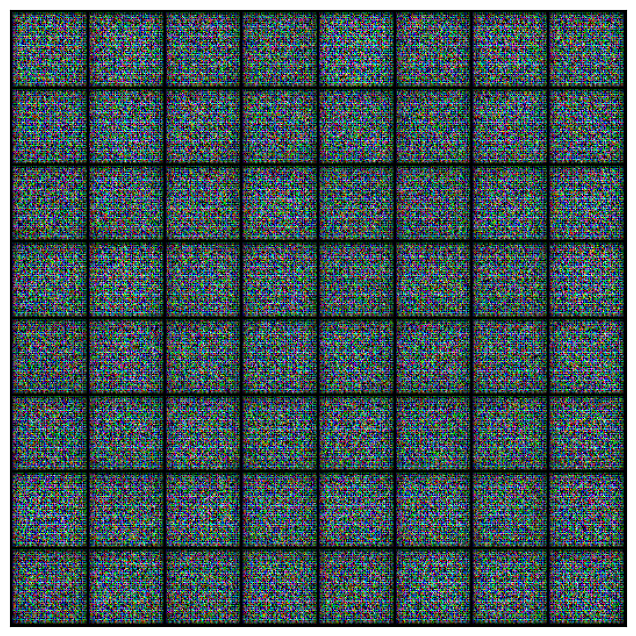

In [35]:
save_samples(0, fixed_latent)

In [36]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [37]:
def fit(epochs, lr, start_idx):
    torch.cuda.empty_cache()

    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)

        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        # Save checkpoint
        if (epoch+1) %10==0:
          checkpoint = {
              'epoch': epoch+start_idx+1,
              'generator_state_dict': generator.state_dict(),
              'discriminator_state_dict': discriminator.state_dict(),
          }
          torch.save(checkpoint, os.path.join(checkpoint_dir, f'checkpoint_epoch_{epoch+start_idx+1}.pth'))

        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))

        # Save generated images
        save_samples(epoch+start_idx+1, fixed_latent, show=False)

    return losses_g, losses_d, real_scores, fake_scores

In [38]:
lr = 0.0002
epochs = 50

In [39]:
jovian.reset()
jovian.log_hyperparams(lr=lr, epochs=epochs)

[jovian] Please enter your API key ( from https://jovian.com/ ):
API KEY: ··········
[jovian] Hyperparams logged.


In [40]:
checkpoint_dir = 'drive/MyDrive/checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

In [41]:
def load_checkpoint(generator, discriminator, filename):
    checkpoint = torch.load(filename, map_location=torch.device('cpu'))
    epoch = checkpoint['epoch']
    generator.load_state_dict(checkpoint['generator_state_dict'])
    discriminator.load_state_dict(checkpoint['discriminator_state_dict'])
    return epoch

# Load checkpoint if it exists, otherwise start from epoch 1
start_epoch = 0
if os.path.exists(checkpoint_dir):
    checkpoint_files = os.listdir(checkpoint_dir)
    if checkpoint_files:
        latest_checkpoint = max(checkpoint_files, key=lambda x: int(x.split('_')[-1].split('.')[0]))
        start_epoch = load_checkpoint(generator, discriminator, os.path.join(checkpoint_dir, latest_checkpoint))
        print(start_epoch)
        print(f"Resuming training from epoch {start_epoch}")

53
Resuming training from epoch 53


In [42]:
start_epoch

53

In [43]:
history = fit(epochs, lr, start_epoch)

  0%|          | 0/161 [00:00<?, ?it/s]

Epoch [1/50], loss_g: 4.1378, loss_d: 0.3175, real_score: 0.9633, fake_score: 0.2204
Saving generated-images-0054.png


  0%|          | 0/161 [00:00<?, ?it/s]

Epoch [2/50], loss_g: 3.6004, loss_d: 0.1861, real_score: 0.8922, fake_score: 0.0586
Saving generated-images-0055.png


  0%|          | 0/161 [00:00<?, ?it/s]

Epoch [3/50], loss_g: 3.7541, loss_d: 0.2034, real_score: 0.9373, fake_score: 0.1183
Saving generated-images-0056.png


  0%|          | 0/161 [00:00<?, ?it/s]

Epoch [4/50], loss_g: 1.8771, loss_d: 0.1729, real_score: 0.8828, fake_score: 0.0408
Saving generated-images-0057.png


  0%|          | 0/161 [00:00<?, ?it/s]

Epoch [5/50], loss_g: 4.0388, loss_d: 0.2577, real_score: 0.9544, fake_score: 0.1754
Saving generated-images-0058.png


  0%|          | 0/161 [00:00<?, ?it/s]

Epoch [6/50], loss_g: 2.1856, loss_d: 0.3261, real_score: 0.7764, fake_score: 0.0484
Saving generated-images-0059.png


  0%|          | 0/161 [00:00<?, ?it/s]

Epoch [7/50], loss_g: 2.6017, loss_d: 0.2011, real_score: 0.8908, fake_score: 0.0724
Saving generated-images-0060.png


  0%|          | 0/161 [00:00<?, ?it/s]

Epoch [8/50], loss_g: 3.5728, loss_d: 0.2778, real_score: 0.8435, fake_score: 0.0846
Saving generated-images-0061.png


  0%|          | 0/161 [00:00<?, ?it/s]

Epoch [9/50], loss_g: 3.5045, loss_d: 0.2867, real_score: 0.9454, fake_score: 0.1831
Saving generated-images-0062.png


  0%|          | 0/161 [00:00<?, ?it/s]

Epoch [10/50], loss_g: 2.3261, loss_d: 0.2788, real_score: 0.7946, fake_score: 0.0259
Saving generated-images-0063.png


  0%|          | 0/161 [00:00<?, ?it/s]

Epoch [11/50], loss_g: 2.6829, loss_d: 0.2564, real_score: 0.8605, fake_score: 0.0820
Saving generated-images-0064.png


  0%|          | 0/161 [00:00<?, ?it/s]

Epoch [12/50], loss_g: 3.3144, loss_d: 0.1395, real_score: 0.9305, fake_score: 0.0568
Saving generated-images-0065.png


  0%|          | 0/161 [00:00<?, ?it/s]

Epoch [13/50], loss_g: 2.6929, loss_d: 0.2150, real_score: 0.8755, fake_score: 0.0632
Saving generated-images-0066.png


  0%|          | 0/161 [00:00<?, ?it/s]

Epoch [14/50], loss_g: 3.1959, loss_d: 0.2467, real_score: 0.8637, fake_score: 0.0804
Saving generated-images-0067.png


  0%|          | 0/161 [00:00<?, ?it/s]

Epoch [15/50], loss_g: 2.0272, loss_d: 0.2723, real_score: 0.7942, fake_score: 0.0215
Saving generated-images-0068.png


  0%|          | 0/161 [00:00<?, ?it/s]

Epoch [16/50], loss_g: 2.3051, loss_d: 0.2664, real_score: 0.8199, fake_score: 0.0454
Saving generated-images-0069.png


  0%|          | 0/161 [00:00<?, ?it/s]

Epoch [17/50], loss_g: 3.5223, loss_d: 0.1325, real_score: 0.9118, fake_score: 0.0335
Saving generated-images-0070.png


  0%|          | 0/161 [00:00<?, ?it/s]

Epoch [18/50], loss_g: 2.7445, loss_d: 0.3747, real_score: 0.8434, fake_score: 0.1472
Saving generated-images-0071.png


  0%|          | 0/161 [00:00<?, ?it/s]

Epoch [19/50], loss_g: 4.1375, loss_d: 0.1550, real_score: 0.9698, fake_score: 0.1065
Saving generated-images-0072.png


  0%|          | 0/161 [00:00<?, ?it/s]

Epoch [20/50], loss_g: 3.5432, loss_d: 0.0736, real_score: 0.9683, fake_score: 0.0385
Saving generated-images-0073.png


  0%|          | 0/161 [00:00<?, ?it/s]

Epoch [21/50], loss_g: 3.3498, loss_d: 0.2246, real_score: 0.9319, fake_score: 0.1257
Saving generated-images-0074.png


  0%|          | 0/161 [00:00<?, ?it/s]

Epoch [22/50], loss_g: 3.2020, loss_d: 0.1998, real_score: 0.8869, fake_score: 0.0648
Saving generated-images-0075.png


  0%|          | 0/161 [00:00<?, ?it/s]

Epoch [23/50], loss_g: 3.5827, loss_d: 0.1981, real_score: 0.8417, fake_score: 0.0077
Saving generated-images-0076.png


  0%|          | 0/161 [00:00<?, ?it/s]

Epoch [24/50], loss_g: 3.2659, loss_d: 0.1977, real_score: 0.8818, fake_score: 0.0552
Saving generated-images-0077.png


  0%|          | 0/161 [00:00<?, ?it/s]

Epoch [25/50], loss_g: 5.0533, loss_d: 0.2112, real_score: 0.9872, fake_score: 0.1671
Saving generated-images-0078.png


  0%|          | 0/161 [00:00<?, ?it/s]

Epoch [26/50], loss_g: 2.9934, loss_d: 1.1366, real_score: 0.8859, fake_score: 0.5060
Saving generated-images-0079.png


  0%|          | 0/161 [00:00<?, ?it/s]

Epoch [27/50], loss_g: 2.5166, loss_d: 0.1992, real_score: 0.8628, fake_score: 0.0385
Saving generated-images-0080.png


  0%|          | 0/161 [00:00<?, ?it/s]

Epoch [28/50], loss_g: 2.1410, loss_d: 0.7563, real_score: 0.5807, fake_score: 0.0569
Saving generated-images-0081.png


  0%|          | 0/161 [00:00<?, ?it/s]

Epoch [29/50], loss_g: 3.4417, loss_d: 0.1204, real_score: 0.9222, fake_score: 0.0345
Saving generated-images-0082.png


  0%|          | 0/161 [00:00<?, ?it/s]

Epoch [30/50], loss_g: 4.1685, loss_d: 0.0899, real_score: 0.9792, fake_score: 0.0628
Saving generated-images-0083.png


  0%|          | 0/161 [00:00<?, ?it/s]

Epoch [31/50], loss_g: 5.7397, loss_d: 0.5911, real_score: 0.9738, fake_score: 0.3507
Saving generated-images-0084.png


  0%|          | 0/161 [00:00<?, ?it/s]

Epoch [32/50], loss_g: 3.3796, loss_d: 0.2042, real_score: 0.9188, fake_score: 0.0952
Saving generated-images-0085.png


  0%|          | 0/161 [00:00<?, ?it/s]

Epoch [33/50], loss_g: 3.4991, loss_d: 0.0928, real_score: 0.9550, fake_score: 0.0414
Saving generated-images-0086.png


  0%|          | 0/161 [00:00<?, ?it/s]

Epoch [34/50], loss_g: 3.6114, loss_d: 0.0845, real_score: 0.9433, fake_score: 0.0240
Saving generated-images-0087.png


  0%|          | 0/161 [00:00<?, ?it/s]

Epoch [35/50], loss_g: 2.7027, loss_d: 0.3031, real_score: 0.8060, fake_score: 0.0523
Saving generated-images-0088.png


  0%|          | 0/161 [00:00<?, ?it/s]

Epoch [36/50], loss_g: 5.0225, loss_d: 0.0832, real_score: 0.9655, fake_score: 0.0432
Saving generated-images-0089.png


  0%|          | 0/161 [00:00<?, ?it/s]

Epoch [37/50], loss_g: 4.3826, loss_d: 0.1044, real_score: 0.9150, fake_score: 0.0108
Saving generated-images-0090.png


  0%|          | 0/161 [00:00<?, ?it/s]

Epoch [38/50], loss_g: 3.5169, loss_d: 0.2432, real_score: 0.9377, fake_score: 0.1435
Saving generated-images-0091.png


  0%|          | 0/161 [00:00<?, ?it/s]

Epoch [39/50], loss_g: 3.4354, loss_d: 0.1788, real_score: 0.9210, fake_score: 0.0791
Saving generated-images-0092.png


  0%|          | 0/161 [00:00<?, ?it/s]

Epoch [40/50], loss_g: 0.1235, loss_d: 4.1570, real_score: 0.0586, fake_score: 0.0051
Saving generated-images-0093.png


  0%|          | 0/161 [00:00<?, ?it/s]

Epoch [41/50], loss_g: 4.1750, loss_d: 0.1627, real_score: 0.9852, fake_score: 0.1283
Saving generated-images-0094.png


  0%|          | 0/161 [00:00<?, ?it/s]

Epoch [42/50], loss_g: 3.9262, loss_d: 0.1219, real_score: 0.9813, fake_score: 0.0902
Saving generated-images-0095.png


  0%|          | 0/161 [00:00<?, ?it/s]

Epoch [43/50], loss_g: 4.7207, loss_d: 0.1414, real_score: 0.9628, fake_score: 0.0899
Saving generated-images-0096.png


  0%|          | 0/161 [00:00<?, ?it/s]

Epoch [44/50], loss_g: 4.2080, loss_d: 0.1350, real_score: 0.8997, fake_score: 0.0206
Saving generated-images-0097.png


  0%|          | 0/161 [00:00<?, ?it/s]

Epoch [45/50], loss_g: 2.5787, loss_d: 1.0177, real_score: 0.6075, fake_score: 0.2151
Saving generated-images-0098.png


  0%|          | 0/161 [00:00<?, ?it/s]

Epoch [46/50], loss_g: 4.4516, loss_d: 0.0753, real_score: 0.9502, fake_score: 0.0211
Saving generated-images-0099.png


  0%|          | 0/161 [00:00<?, ?it/s]

Epoch [47/50], loss_g: 5.0501, loss_d: 0.0759, real_score: 0.9494, fake_score: 0.0218
Saving generated-images-0100.png


  0%|          | 0/161 [00:00<?, ?it/s]

Epoch [48/50], loss_g: 3.6566, loss_d: 0.1450, real_score: 0.8968, fake_score: 0.0265
Saving generated-images-0101.png


  0%|          | 0/161 [00:00<?, ?it/s]

Epoch [49/50], loss_g: 4.2681, loss_d: 0.0633, real_score: 0.9706, fake_score: 0.0306
Saving generated-images-0102.png


  0%|          | 0/161 [00:00<?, ?it/s]

Epoch [50/50], loss_g: 3.6665, loss_d: 0.1724, real_score: 0.9405, fake_score: 0.0884
Saving generated-images-0103.png


In [ ]:
losses_g, losses_d, real_scores, fake_scores = history

In [ ]:
jovian.log_metrics(loss_g=losses_g[-1],
                   loss_d=losses_d[-1],
                   real_score=real_scores[-1],
                   fake_score=fake_scores[-1])

[jovian] Metrics logged.


In [ ]:
# Save the model checkpoints
torch.save(generator.state_dict(), 'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')

In [ ]:
from IPython.display import Image

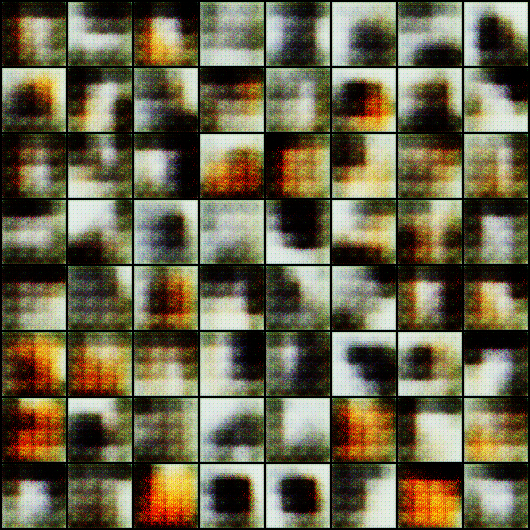

In [ ]:
Image('./generated/generated-images-0001.png')

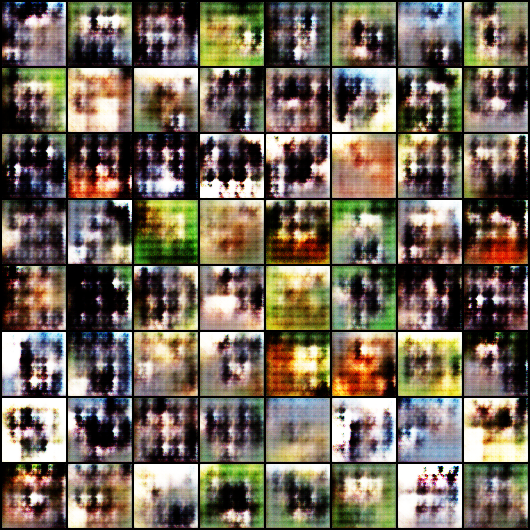

In [ ]:
Image('./generated/generated-images-0005.png')

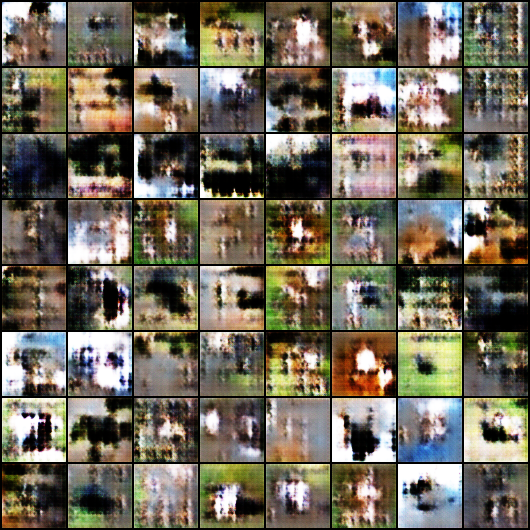

In [ ]:
Image('./generated/generated-images-0010.png')

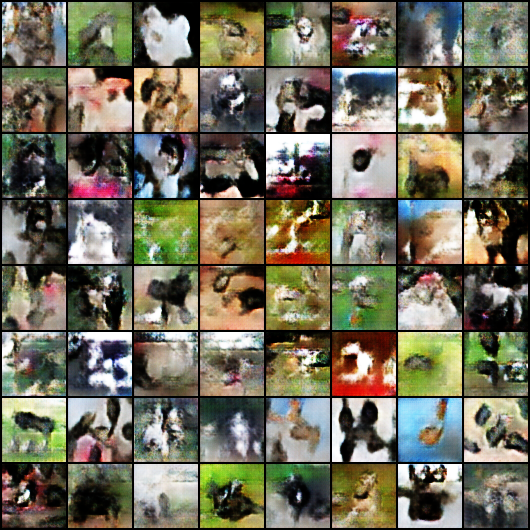

In [ ]:
Image('./generated/generated-images-0020.png')

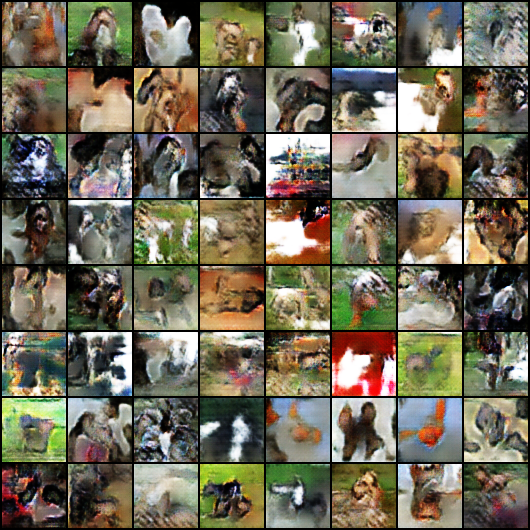

In [ ]:
Image('./generated/generated-images-0025.png')

In [ ]:
import cv2
import os

vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

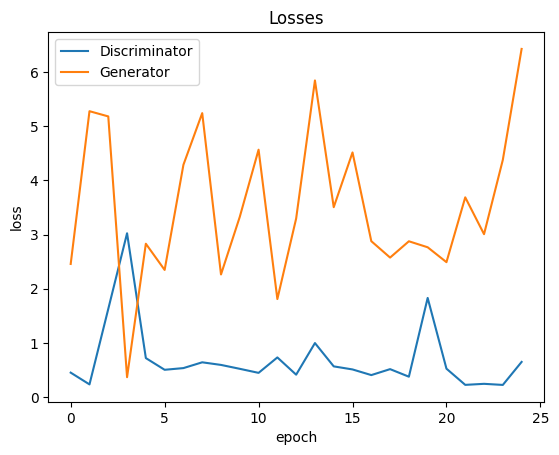

In [ ]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

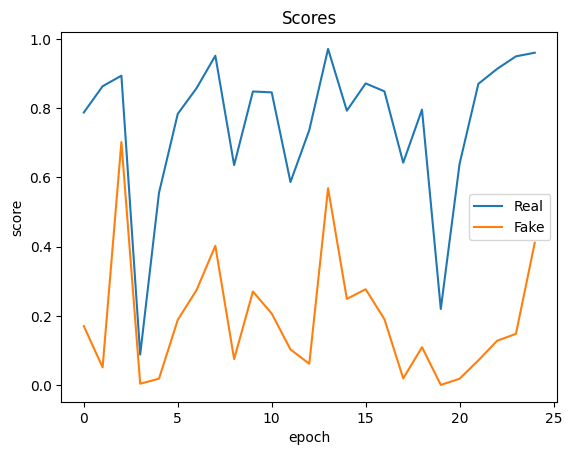

In [ ]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');